# 疎行列-sparse

科学や工学の分野で線形モデルを解く際に、多くの大規模な行列が頻繁に現れます。これらの行列の大部分の要素は0であり、疎行列と呼ばれます。NumPyの`ndarray`配列でこのような行列を保存するとメモリが無駄になります。行列の疎な特性を利用して、非ゼロ要素の関連情報のみを保存することで、メモリの使用を節約できます。さらに、この特殊な構造を持つ行列に対して設計された演算関数を使用することで、行列の演算速度を向上させることができます。

`scipy.sparse`では、疎行列を表すためのさまざまな形式が提供されています。`scipy.sparse.linalg`は、これらの行列に対して線形代数演算を行う関数を提供し、`scipy.sparse.csgraph`は疎行列で表されたグラフを探索する関数を提供します。このセクションでは、まず疎行列を表すさまざまな形式を紹介し、次に線形代数関数を使用して大規模な線形方程式を解く方法を紹介し、最後に`csgraph`の関数を使用して最適な経路を探索する方法を紹介します。

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import helper.matplotlib
import helper.magics
from scipy import sparse
from scipy.sparse import csgraph

## 疎行列の保存形式

`scipy.sparse`では、疎行列を表すためのさまざまな形式が提供されています。それぞれの形式には異なる用途があり、その中でも`dok_matrix`と`lil_matrix`は要素を徐々に追加するのに適しています。

`dok_matrix`は`dict`から継承されており、辞書を使用して行列の非ゼロ要素を保存します。辞書のキーは要素の（行、列）情報を保存するタプルであり、対応する値は行列の（行、列）位置にある要素の値です。明らかに、辞書形式の疎行列は単一の要素の追加、削除、およびアクセス操作に適しています。通常、非ゼロ要素を1つずつ追加し、その後、高速な演算をサポートする他の形式に変換するために使用されます。

In [2]:
from scipy import sparse

a = sparse.dok_matrix((10, 5))
a[2:5, 3] = 1.0, 2.0, 3.0
print(a.keys())
print(a.values())

dict_keys([(2, 3), (3, 3), (4, 3)])
dict_values([1.0, 2.0, 3.0])


`lil_matrix`は2つのリストを使用して非ゼロ要素を保存します。`data`は各行の非ゼロ要素を保存し、`rows`は非ゼロ要素が存在する列を保存します。この形式も要素を1つずつ追加するのに適しており、行に関連するデータを迅速に取得できます。

In [3]:
b = sparse.lil_matrix((10, 5))
b[2, 3] = 1.0
b[3, 4] = 2.0
b[3, 2] = 3.0
print(b.data)
print(b.rows)

[list([]) list([]) list([1.0]) list([3.0, 2.0]) list([]) list([]) list([])
 list([]) list([]) list([])]
[list([]) list([]) list([3]) list([2, 4]) list([]) list([]) list([])
 list([]) list([]) list([])]


`coo_matrix`は3つの配列`row`、`col`、`data`を使用して非ゼロ要素の情報を保存します。これらの3つの配列の長さは同じで、`row`は要素の行を保存し、`col`は要素の列を保存し、`data`は要素の値を保存します。`coo_matrix`は要素のアクセスや追加、削除をサポートしていません。一度作成されると、他の形式の行列に変換する以外、ほとんど何も操作や行列演算を行うことができません。

`coo_matrix`は重複する要素をサポートしており、同じ行と列のインデックスが複数回出現することがあります。他の形式の行列に変換する際、同じ行と列のインデックスに対応する複数の値が合計されます。以下の例では、`(2, 3)`は2つの値：1と10に対応しています。これを`ndarray`配列に変換する際、これらの値が加算されるため、最終的な行列の`(2, 3)`インデックスの値は11になります。

多くの疎行列のデータは、この形式でファイルに保存されています。例えば、あるCSVファイルには「ユーザーID、商品ID、評価値」という3つの列があるかもしれません。`numpy.loadtxt`や`pandas.read_csv`を使用してデータを読み込んだ後、`coo_matrix`を使用して迅速に疎行列に変換できます。行列の各行は1人のユーザーに対応し、各列は1つの商品に対応し、要素の値はユーザーが商品に与えた評価です。

In [4]:
row = [2, 3, 3, 2]
col = [3, 4, 2, 3]
data = [1, 2, 3, 10]
c = sparse.coo_matrix((data, (row, col)), shape=(5, 6))
print(c.col, c.row, c.data)
print(c.toarray())

[3 4 2 3] [2 3 3 2] [ 1  2  3 10]
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  0  3  0  2  0]
 [ 0  0  0  0  0  0]]


## 大規模な線形方程式の解法

疎行列の線形代数ライブラリを使用することで、大規模な線形方程式を解くことができます。このセクションでは、総変動モデルに基づく画像修復を例として、SciPyが提供する疎行列線形代数ライブラリの使用方法を紹介します。次のグラフでは、左側が元の画像で、右側の画像は元の画像に白い文字を追加したものです。右側の画像の白い文字部分を、元の画像に似たグレースケールに修復したいと考えています。

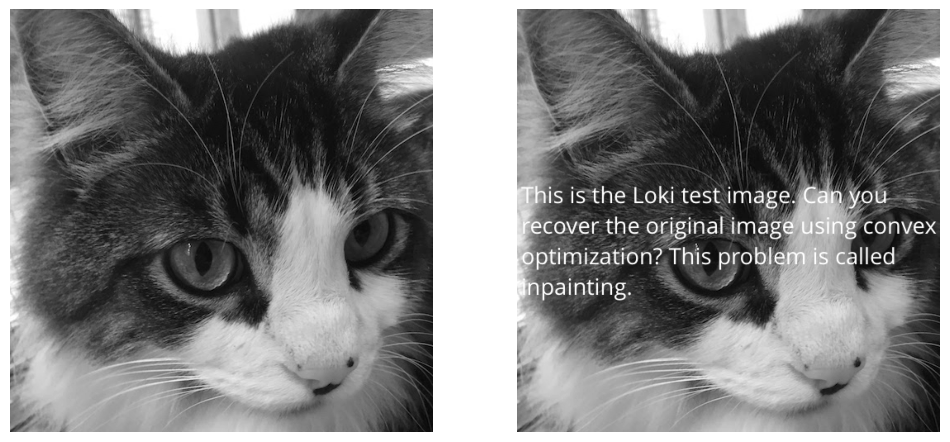

In [6]:
from pylab import imread

img1 = imread("data/loki512.png")
img2 = imread("data/loki512_corrupted.png")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
for ax in axes:
    ax.axis("off")

修復が必要な各ピクセルは、そのピクセルのグレースケール値を表す未知数に対応します。修復された各ピクセルが、その隣接する4つのピクセルの平均値と等しくなるようにしたいと考えています。つまり、以下の方程式を満たすようにします。ここで、$D_{i,j}$はインデックス$(i, j)$のピクセルのグレースケール値です。

$$4 D_{i,j} - D_{i-1,j} - D_{i+1,j} - D_{i,j-1} - D_{i,j+1} = 0$$

上記の方程式では、$D_{i,j}$はすべて修復対象のピクセルの未知数を表し、その隣接するピクセル$D_{i-1,j}$、$D_{i+1,j}$、$D_{i,j-1}$、$D_{i,j+1}$は既知の値または未知数である可能性があります。したがって、各方程式には少なくとも1つの未知数があり、最大で5つの未知数があります。

例えば、次のグラフ（左）では、空白のマス目が修復が必要なピクセルを示しており、各空白のマス目に未知数$X_i$を割り当てます。その結果は次のグラフ（右）に示されています。各未知数に対して1つの方程式を立てることができます。例えば、$X_0$に対応する方程式は次のようになります。

$$4 X_0 - X_1 - X_3 = 2 + 3$$

$X_5$に対応する方程式は次のようになります。

$$4 X_5 - X_2 - X_6 - X_7 - X_4 = 0$$

これらの9つの方程式からなる連立方程式を解くことで、各未知ピクセルのグレースケール値を得ることができます。NumPyが提供する`numpy.linalg.solve()`を使用して、このような線形方程式を解くことができます。しかし、未知数の数は未知領域のピクセル数に等しいため、通常、画像修復に関連する未知数は非常に多くなります。例えば、$100 \times 100$の領域を修復するためには、$10000 \times 10000$の係数行列$\mathbf{A}$を作成する必要があります。

明らかに、係数行列$\mathbf{A}$は疎行列であり、SciPyの疎行列線形代数ライブラリが提供する`spsolve()`を使用して高速に解くことができます。残る問題は、`spsolve()`に必要な2つの係数行列$\mathbf{A}$と$\mathbf{b}$を作成する方法です。

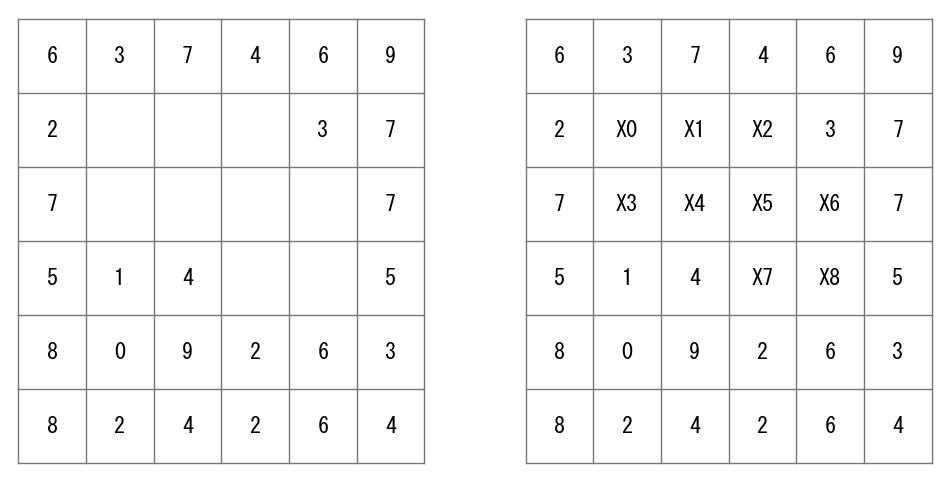

In [8]:
from helper.matplotlib import draw_grid

np.random.seed(42)
a = np.random.randint(0, 10, (6, 6)).astype(str)
a[1:3, 1:4] = ""
a[2:4, 3:5] = ""

iy, ix = np.where(a == "")
b = a.copy()
b[iy, ix] = ["X{}".format(i) for i in range(len(iy))]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax in axes:
    ax.axis("off")
draw_grid(axes[0], a)
draw_grid(axes[1], b)

まず、画像`img1`と`img2`のグレースケール値が異なるピクセルの座標`Y`と`X`を取得します。これらが修復対象のピクセルです。隣接するピクセルが未知数か既知数かを区別するために、画像と同じ形状の`variables`配列を使用して、各修復対象ピクセルに対応する未知数のインデックスを保存します。値が`-1`の場合、そのピクセルのグレースケール値は既知であることを示します。

In [9]:
Y, X = np.where(img1 != img2)
variables = np.full(img1.shape, -1, int)
variables[Y, X] = np.arange(len(X))

`dok_matrix`を使用して、行列の非ゼロ要素を1つずつ設定できます。❶方程式のインデックスは中心の未知数のインデックスと同じであり、係数行列$\mathbf{A}$の対角線上のすべての要素は4です。❷`variables`を使用して隣接する未知数のインデックスを見つけます。そのインデックスが非負の場合、それは未知数であることを示し、❸行列のインデックス`(v, v2)`の要素を-1に設定します。❹そうでない場合、定数配列のインデックス`v`の要素に既知の値を累積します。

In [10]:
%%time
A = sparse.dok_matrix((len(X), len(X)))
b = sparse.dok_matrix((len(X), 1))

neighbours = [(-1, 0), (1, 0), (0, -1), (0, 1)]

for v, (y, x) in enumerate(zip(Y, X)):
    A[v, v] = 4  #❶ 対角線上の要素の係数
    for dy, dx in neighbours:
        y2, x2 = y + dy, x + dx
        v2 = variables[y2, x2]  #❷ 隣接する未知数のインデックスを取得
        if v2 >= 0:
            A[v, v2] = -1  #❸ 隣接する未知数の係数を設定
        else:
            b[v] += img2[y2, x2]  #❹ 定数配列の要素に画像のピクセル値を累積

CPU times: total: 1.31 s
Wall time: 1.35 s


2つの係数行列を作成した後、`tocsc()`メソッドを使用して`csc_matrix`形式の行列に変換し、計算を行います。`linalg.spsolve()`を呼び出すことで、線形方程式の解を得ることができます。最後に、解を修復対象の画像の対応するインデックスに書き戻すことで、修復された画像の結果を得ます。次のグラフには修復結果（左）と元の画像との誤差（右）が表示されています。

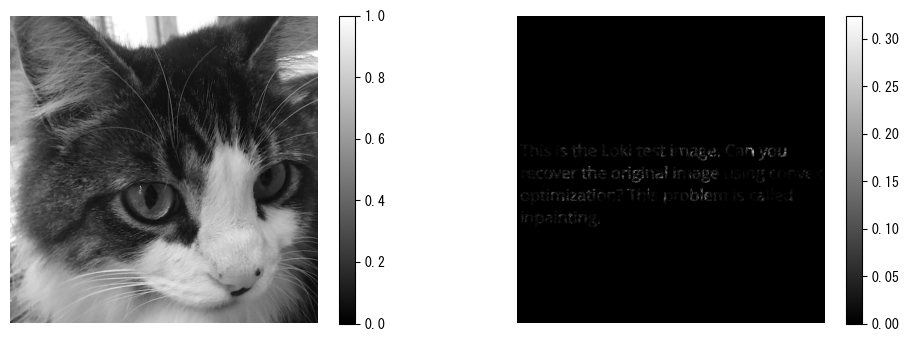

In [11]:
from scipy.sparse import linalg

Ac = A.tocsc()
bc = b.tocsc()

x = linalg.spsolve(Ac, bc)

img3 = img2.copy()
img3[Y, X] = x

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im = axes[0].imshow(img3, cmap="gray")
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(np.abs(img3 - img1), cmap="gray")
plt.colorbar(im, ax=axes[1])
for ax in axes:
    ax.axis("off")

ループ内で`dok_matrix`の要素を設定するのは効率的ではありません。疎行列の作成効率を向上させるために、以下の`RCD`クラスを使用できます。その`append()`メソッドは、3つのリストを使用して要素の行インデックス、列インデックス、および要素値をそれぞれ収集します。❶パラメータに`numpy.broadcast_arrays()`を使用してブロードキャスト処理を行うため、パラメータは1次元配列または単一の数値にすることができます。❷`tocoo()`は`RCD`オブジェクトを`coo_matrix`行列に変換し、❸`tocsc()`は`RCD`オブジェクトを`csc_matrix`行列に変換します。`coo_matrix()`は重複するインデックスの要素を累積処理するため、係数行列$\mathbf{b}$の累積演算を実装するのにちょうど適しています。

In [12]:
class RCD:
    def __init__(self, shape):
        self.row = []
        self.col = []
        self.dat = []
        self.shape = shape

    def append(self, r, c, d):
        r, c, d = np.broadcast_arrays(r, c, d)  #❶
        self.row.append(r)
        self.col.append(c)
        self.dat.append(d)

    def tocoo(self):  #❷
        row = np.concatenate(self.row)
        col = np.concatenate(self.col)
        dat = np.concatenate(self.dat)
        return sparse.coo_matrix((dat, (row, col)), shape=self.shape)

    def tocsc(self):  #❸
        return self.tocoo().tocsc()

以下では、`RCD`オブジェクトを使用して係数行列を作成します。NumPy配列のベクトル演算を使用しているため、4つの隣接方向に対してのみループを行う必要があります。この方法は、`dok_matrix`行列に要素を1つずつ追加する二重ループよりも数百倍高速です。

In [13]:
%%time
V = np.arange(len(X))

A = RCD((len(X), len(X)))
b = RCD((len(X), 1))

A.append(V, V, 4)

for dy, dx in neighbours:
    Y2, X2 = Y + dy, X + dx
    V2 = variables[Y2, X2]
    D2 = img2[Y2, X2]

    mask = V2 >= 0
    nmask = ~mask
    A.append(V[mask], V2[mask], -1)
    b.append(V[nmask], 0, D2[nmask])

Ac = A.tocsc()
bc = b.tocsc()

CPU times: total: 0 ns
Wall time: 21.6 ms


最後に、線形方程式を解き、前の計算結果と比較します。

In [14]:
x2 = linalg.spsolve(Ac, bc)
np.allclose(x, x2)

True

## 最短経路

疎行列`w`はグラフを表すために使用でき、`w[i, j]`はグラフのノード`i`とノード`j`の間の経路の重みを保持します。ノード`i`と`j`の間に直接の経路がない場合、疎行列にはそのインデックスが含まれないため、疎行列を使用して重みが0の経路を表すことができます。

```{mermaid}
flowchart LR
A --10--> B
B --5--> C
A --3--> C
C --7--> D
D --4--> A
D --6--> C
```

上のグラフのA、B、C、Dの4つのノードにそれぞれ0、1、2、3と番号を付け、以下の疎行列を構築します。疎行列を配列として表示する場合、行列内で設定されていない値はデフォルトで0になりますが、これはグラフに重みが0の辺があることを意味しません。疎行列で無向グラフを表す場合、`w[i, j]`または`w[j, i]`のいずれかを設定するだけで十分です。

In [15]:
w = sparse.dok_matrix((4, 4))

edges = [(0, 1, 10), (1, 2, 5), (0, 2, 3), (2, 3, 7), (3, 0, 4), (3, 2, 6)]

for i, j, v in edges:
    w[i, j] = v

w.todense()

matrix([[ 0., 10.,  3.,  0.],
        [ 0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  7.],
        [ 4.,  0.,  6.,  0.]])

`scipy.sparse.scgraph`モジュールを使用して、グラフ内の最短経路を見つけることができます。以下の例では、最短経路関数の使用方法を説明します。

次のグラフ（左）は迷路の画像で、その中の黒い曲線は`scgraph`モジュールを使用して座標`(sx, sy)`から`(ex, ey)`までの最短経路を求めたものです。❶計算を容易にするために、以下のコードではカラーの迷路画像を閾値処理して白黒の二値画像に変換し、黒色は壁、白色は通路を表します。❷迷路の外部の余白を通路として誤認しないように、以下のプログラムでは中央の両側に2本の黒い線を追加し、余白を上下に分割します。上記の処理を施した後の迷路は次のグラフ（右）のようになります。

In [16]:
img = plt.imread("data/maze.png")
sx, sy = (400, 979)
ex, ey = (398, 25)
bimg = np.all(img > 0.81, axis=2)  #❶
H, W = bimg.shape

x0, x1 = np.where(bimg[H // 2, :] == 0)[0][[0, -1]]  #❷
bimg[H // 2, :x0] = 0
bimg[H // 2, x1:] = 0

迷路内のすべてのピクセルをグラフのノードとして扱い、ノード番号とピクセル座標`(x, y)`の関係は`idx = y * W + x`で計算します。❶上下に隣接する白色ピクセルと左右に隣接する白色ピクセルのペアをすべて見つけ、対応するノード番号を形状`(N, 2)`の`edges`配列に保存します。`N`はグラフに含まれる辺の数です。❷`coo_matrix()`を使用して疎行列を作成し、すべての辺の重みを1に設定します。

In [17]:
# 上下に隣接する白色ピクセル
mask = bimg[1:, :] & bimg[:-1, :]
idx = np.where(mask.ravel())[0]
vedge = np.c_[idx, idx + W]

# 左右に隣接する白色ピクセル
mask = bimg[:, 1:] & bimg[:, :-1]
y, x = np.where(mask)
idx = y * W + x
hedge = np.c_[idx, idx + 1]

edges = np.vstack([vedge, hedge])  #❶

values = np.ones(edges.shape[0])
w = sparse.coo_matrix(
    (values, (edges[:, 0], edges[:, 1])), shape=(bimg.size, bimg.size)  #❷
)

次に、`csgraph`モジュールをインポートし、`dijkstra()`を呼び出して、番号`startid`のノードから他のすべてのノードへの最短経路を計算します。`directed`パラメータを`False`に設定すると無向グラフを表し、最短経路を計算するために`return_predecessors`パラメータを`True`に設定する必要があります。返される配列`d`と`p`の形状は（`indices`パラメータの長さ、グラフの総ノード数）です。

In [20]:
from scipy.sparse import csgraph

startid = sy * W + sx
endid = ey * W + ex
d, p = csgraph.dijkstra(w, indices=[startid], return_predecessors=True, directed=False)
%C d.shape; p.shape

  d.shape      p.shape  
-----------  -----------
(1, 801600)  (1, 801600)


`d[i, j]`は、番号`indices[i]`のノードから番号`j`のノードまでの距離を保持します。2つのノード間に経路がない場合、値は`inf`になります。以下は、起点から到達できないノードの数を計算します。これらのノードには、迷路内の黒色ピクセルで表される壁や、黒色ピクセルに完全に囲まれた領域が含まれます。

In [21]:
np.isinf(d[0]).sum()

322324

`p[i, j]`は、ノード`indices[i]`からノード`j`までの経路の最後のノードの番号を保持します。以下のコードは、番号`endid`のノードから始めて、`startid`ノードが見つかるまで遡ります。訪問したノードを`path`に保存します。`path`を反転させると、起点から終点までの経路が得られます。

In [22]:
path = []
node_id = endid
while True:
    path.append(node_id)
    if node_id == startid or node_id < 0:
        break
    node_id = p[0, node_id]
path = np.array(path)

最後に、元の迷路画像で`path`が通過するピクセルを黒く塗りつぶし、次のグラフ（左）の経路を得ます。

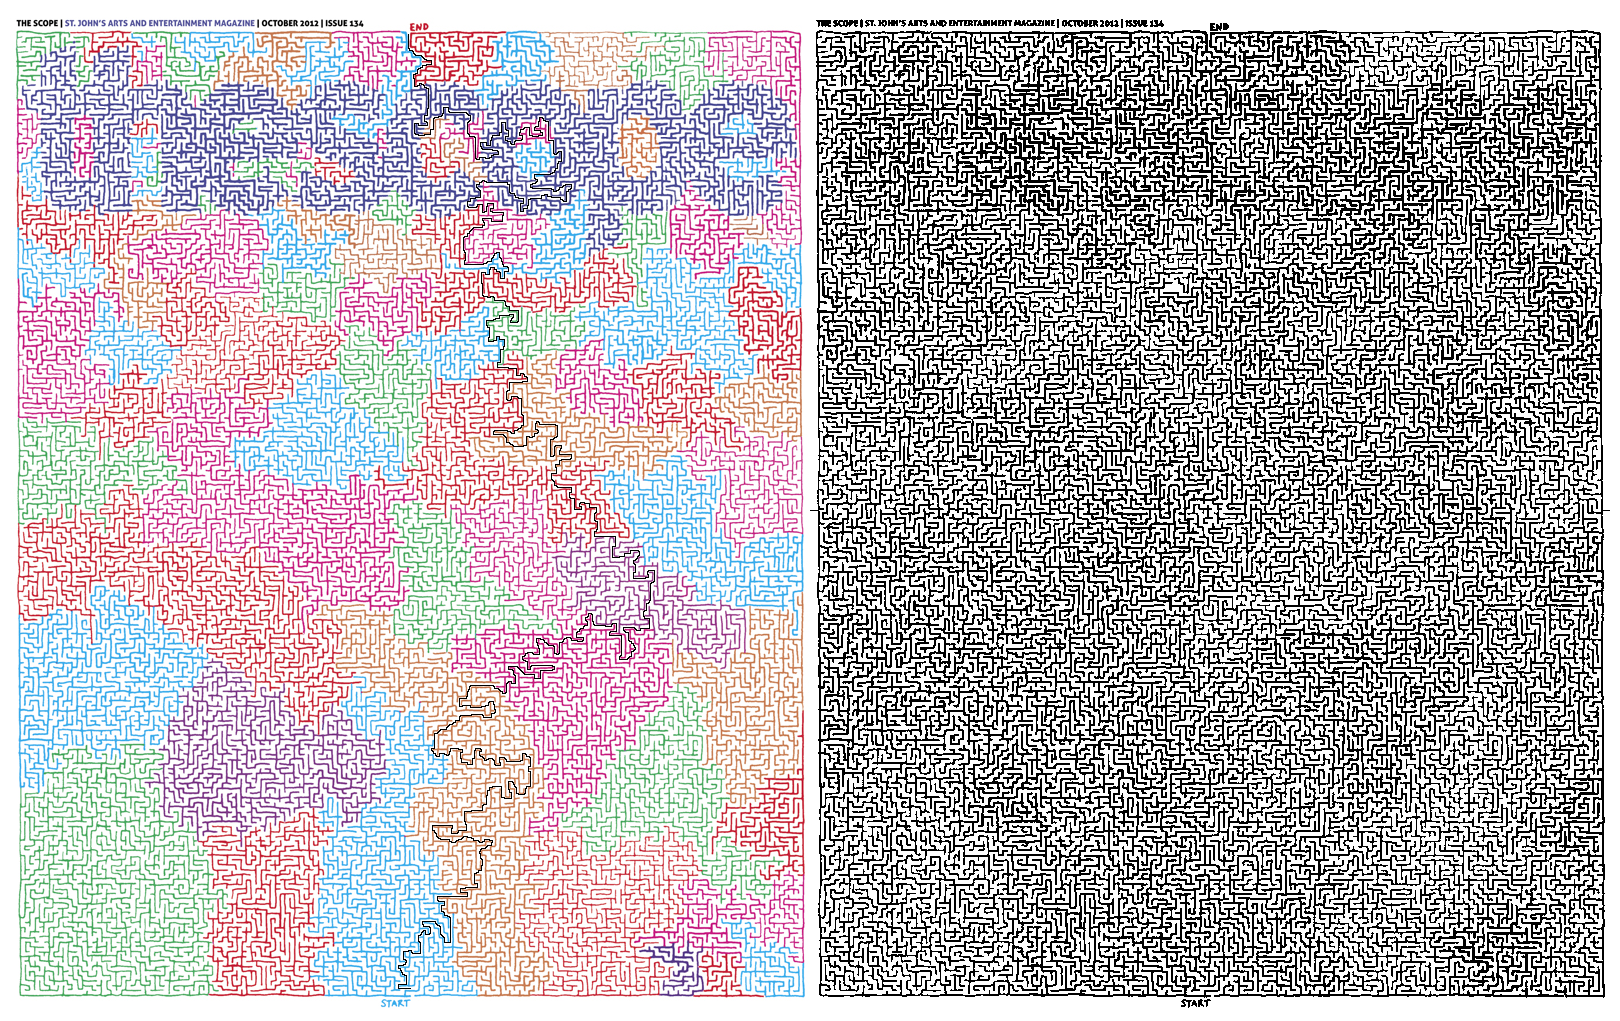

In [23]:
x, y = path % W, path // W
img[y, x, :] = 0
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
axes[0].imshow(img)
axes[1].imshow(bimg, cmap="gray")
for ax in axes:
    ax.axis("off")
fig.subplots_adjust(0, 0, 1, 1, 0, 0)

上記の迷路では、2つの隣接する白色ピクセル間の経路の重みはすべて1であるため、検索された最適経路は最短経路です。多くのゲームマップでは、地形要因を考慮して経路検索が行われます。この場合、異なる地形に応じて異なる大きさの経路重みを設定することができ、最適経路はすべての重みの合計が最小となる経路です。